In [3]:
# CONTROL FOR NON_PROFIT, PRED = 4 year


# https://dqydj.com/average-income-by-state-median-top-percentiles/
import pandas as pd
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

In [4]:
all_dfs_year = []

left_year = 2000
right_year = 1
urls = []
while 1 != 0:
    if right_year > 20:
        break
        
    try:
        if right_year == 100:
            right_year = 0

        if right_year < 10:   
            url = 'Downloads/Data_Final/MERGED' + str(left_year) + '_' + '0' + str(right_year) + '_PP.csv'
        else:
            url = 'Downloads/Data_Final/MERGED' + str(left_year) + '_' + str(right_year) + '_PP.csv'

        all_dfs_year.append(pd.read_csv(url))
        urls.append(url)

        left_year += 1
        right_year += 1
    except:
        break

In [5]:
urls

['Downloads/Data_Final/MERGED2000_01_PP.csv',
 'Downloads/Data_Final/MERGED2001_02_PP.csv',
 'Downloads/Data_Final/MERGED2002_03_PP.csv',
 'Downloads/Data_Final/MERGED2003_04_PP.csv',
 'Downloads/Data_Final/MERGED2004_05_PP.csv',
 'Downloads/Data_Final/MERGED2005_06_PP.csv',
 'Downloads/Data_Final/MERGED2006_07_PP.csv',
 'Downloads/Data_Final/MERGED2007_08_PP.csv',
 'Downloads/Data_Final/MERGED2008_09_PP.csv',
 'Downloads/Data_Final/MERGED2009_10_PP.csv',
 'Downloads/Data_Final/MERGED2010_11_PP.csv',
 'Downloads/Data_Final/MERGED2011_12_PP.csv',
 'Downloads/Data_Final/MERGED2012_13_PP.csv',
 'Downloads/Data_Final/MERGED2013_14_PP.csv',
 'Downloads/Data_Final/MERGED2014_15_PP.csv',
 'Downloads/Data_Final/MERGED2015_16_PP.csv',
 'Downloads/Data_Final/MERGED2016_17_PP.csv',
 'Downloads/Data_Final/MERGED2017_18_PP.csv',
 'Downloads/Data_Final/MERGED2018_19_PP.csv',
 'Downloads/Data_Final/MERGED2019_20_PP.csv']

In [6]:
similar_columns = all_dfs_year[0].columns
for i in range(0,20):
    similar_columns = similar_columns.intersection(all_dfs_year[i].columns)

Clean Up the Data

In [7]:
# Get Colleges We Want To Look At
import requests
from bs4 import BeautifulSoup

def get_college_data():
    page = requests.get("https://www.4icu.org/us/non-profit/")

    soup = BeautifulSoup(page.content, 'html.parser')

    table = soup.find("table")

    rows=list()
    for row in table.findAll("a"):
        rows.append(row.get_text())
    colleges = rows[12:]

    links = []
    for row in table.findAll('a'):
        link = 'https://www.4icu.org/' + row.get('href')
        links.append(link)

    links = links[12:]
    dates = []

    for l in links:
        page = requests.get(l)
        soup = BeautifulSoup(page.content, 'html.parser')
        try:
            dates.append(int(soup.select_one("span[itemprop=foundingDate]").get_text()))
        except:
            dates.append(None)

    dates = dates[:len(colleges)]

    return (colleges, links, dates)

vals = get_college_data()
colleges = vals[0]
links = vals[1]
dates = vals[2]

In [8]:
import re
import time
import operator

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import csr_matrix
import pandas as pd

import sparse_dot_topn.sparse_dot_topn as ct

# Let's try to get a good match on the first 500 schools
class StringMatch():
    
    def __init__(self, source_names, target_names):
        self.source_names = source_names
        self.target_names = target_names
        self.ct_vect      = None
        self.tfidf_vect   = None
        self.vocab        = None
        self.sprse_mtx    = None
        
        
    def tokenize(self, analyzer='char_wb', n=3):
        '''
        Tokenizes the list of strings, based on the selected analyzer
        :param str analyzer: Type of analyzer ('char_wb', 'word'). Default is trigram
        :param str n: If using n-gram analyzer, the gram length
        '''
        # Create initial count vectorizer & fit it on both lists to get vocab
        self.ct_vect = CountVectorizer(analyzer=analyzer, ngram_range=(n, n))
        self.vocab   = self.ct_vect.fit(self.source_names + self.target_names).vocabulary_
        
        # Create tf-idf vectorizer
        self.tfidf_vect  = TfidfVectorizer(vocabulary=self.vocab, analyzer=analyzer, ngram_range=(n, n))
        
        
    def match(self, ntop=1, lower_bound=0, output_fmt='df'):
        '''
        Main match function. Default settings return only the top candidate for every source string.
        
        :param int ntop: The number of top-n candidates that should be returned
        :param float lower_bound: The lower-bound threshold for keeping a candidate, between 0-1.
                                   Default set to 0, so consider all canidates
        :param str output_fmt: The output format. Either dataframe ('df') or dict ('dict')
        '''
        self._awesome_cossim_top(ntop, lower_bound)
        
        if output_fmt == 'df':
            match_output = self._make_matchdf()
        elif output_fmt == 'dict':
            match_output = self._make_matchdict()
            
        return match_output
        
        
    def _awesome_cossim_top(self, ntop, lower_bound):
        ''' https://gist.github.com/ymwdalex/5c363ddc1af447a9ff0b58ba14828fd6#file-awesome_sparse_dot_top-py '''
        # To CSR Matrix, if needed
        A = self.tfidf_vect.fit_transform(self.source_names).tocsr()
        B = self.tfidf_vect.fit_transform(self.target_names).transpose().tocsr()
        M, _ = A.shape
        _, N = B.shape

        idx_dtype = np.int32

        nnz_max = M * ntop

        indptr = np.zeros(M+1, dtype=idx_dtype)
        indices = np.zeros(nnz_max, dtype=idx_dtype)
        data = np.zeros(nnz_max, dtype=A.dtype)

        ct.sparse_dot_topn(
            M, N, np.asarray(A.indptr, dtype=idx_dtype),
            np.asarray(A.indices, dtype=idx_dtype),
            A.data,
            np.asarray(B.indptr, dtype=idx_dtype),
            np.asarray(B.indices, dtype=idx_dtype),
            B.data,
            ntop,
            lower_bound,
            indptr, indices, data)

        self.sprse_mtx = csr_matrix((data,indices,indptr), shape=(M,N))
    
    
    def _make_matchdf(self):
        ''' Build dataframe for result return '''
        # CSR matrix -> COO matrix
        cx = self.sprse_mtx.tocoo()

        # COO matrix to list of tuples
        match_list = []
        for row,col,val in zip(cx.row, cx.col, cx.data):
            match_list.append((row, self.source_names[row], col, self.target_names[col], val))

        # List of tuples to dataframe
        colnames = ['Row Idx', 'Title', 'Candidate Idx', 'Candidate Title', 'Score']
        match_df = pd.DataFrame(match_list, columns=colnames)

        return match_df


In [9]:
def remove_punct(x):
    x = re.sub(r'[^\w\s-]','',x)
    return re.sub(r'-', ' ', x)

def match_colleges(college_names, data):

    colleges = [remove_punct(x) for x in college_names]
    data['NAME'] = data['INSTNM'].apply(remove_punct)

    matches = StringMatch(colleges, list(data['NAME']))
    matches.tokenize()
    
    matched = matches.match()
    matched['Year_Founded'] = dates
    matched = matched[matched['Score'] > 0.88]
    
    return (data.iloc[matched['Candidate Idx']].copy(), matched['Year_Founded'])

In [10]:
for df in all_dfs_year:
    print(df['SAT_AVG'].isnull().sum()/len(df))
    
yr = list(range(2000,2020))

1.0
0.8111524163568773
0.7914912808177992
0.7831560017982916
0.7784200385356455
0.781852442382954
0.7872248597324126
0.7879787691866303
0.7929128277817151
0.7979769987529445
0.8076305220883534
0.8155176865478957
0.8172220808954465
0.8181471597407549
0.8308009271182075
0.8314636055309157
0.8187344570323294
0.8143982002249719
0.8090201263405318
0.8090827606812071


In [55]:
ind = 0
for df in all_dfs_year:
    print(yr[ind], df['MD_EARN_WNE_P10'].isnull().sum()/len(df))
    ind += 1

2000 1.0
2001 1.0
2002 1.0
2003 1.0
2004 1.0
2005 1.0
2006 1.0
2007 0.10744512982355472
2008 1.0
2009 0.11126506858805597
2010 1.0
2011 0.1265169119545572
2012 0.10900534215212414
2013 0.10725632227729064
2014 0.10494463044038115
2015 1.0
2016 1.0
2017 1.0
2018 1.0
2019 1.0


In [11]:
def create_college_data(years):    
    college_data = pd.DataFrame()
    index = 0
    for d in all_dfs_year:
        curr_data = d[similar_columns]
        yr = int(urls[index].split('MERGED')[1][:4])
        print(yr)

        if yr in years:
            c,year_f = match_colleges(colleges, curr_data)
            c['Year'] = yr
            c['Year_Founded'] = 0
            c['Year_Founded'] = list(year_f)
            college_data = college_data.append(c)

        index += 1
    college_data['Year_Since_Founding'] = college_data['Year'] - college_data['Year_Founded']
    return college_data

college_data = create_college_data(yr)
display(college_data.head())
print(college_data.shape)

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,ROOMBOARD_OFF,OTHEREXPENSE_OFF,OTHEREXPENSE_FAM,ENDOWBEGIN,ENDOWEND,DOLPROVIDER,NAME,Year,Year_Founded,Year_Since_Founding
2043,166683,00217800,2178,Massachusetts Institute of Technology,Cambridge,MA,02139-4307,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Massachusetts Institute of Technology,2000,1861.0,139.0
2019,166027,00215500,2155,Harvard University,Cambridge,MA,02138,NaN,NaN,NaN,...,7982.0,1440.0,1440.0,NaN,NaN,NaN,Harvard University,2000,1636.0,364.0
4972,243744,00130500,1305,Stanford University,Stanford,CA,94305,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Stanford University,2000,1885.0,115.0
2875,190415,002711A1,2711,Cornell University,Ithaca,NY,14853,NaN,NaN,NaN,...,8131.0,1190.0,1190.0,NaN,NaN,NaN,Cornell University,2000,1865.0,135.0
291,110635,131200,1312,University of California-Berkeley,Berkeley,CA,94720,NaN,NaN,NaN,...,8094.0,2032.0,2062.0,NaN,NaN,NaN,University of California Berkeley,2000,1868.0,132.0


(31149, 2396)


In [12]:
all_data_copy = college_data.copy()
college_data = college_data.query('Year == 2007 | Year == 2011 | Year == 2014')

In [13]:
### DELETE THIS BOX!!!!!!!1
college_data = all_data_copy.query('Year == 2007 | Year == 2011 | Year == 2014')
college_data

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,ROOMBOARD_OFF,OTHEREXPENSE_OFF,OTHEREXPENSE_FAM,ENDOWBEGIN,ENDOWEND,DOLPROVIDER,NAME,Year,Year_Founded,Year_Since_Founding
1892,166683,217800,2178,Massachusetts Institute of Technology,Cambridge,MA,02139-4307,NaN,NaN,NaN,...,NaN,NaN,NaN,8.368066e+09,9.980409e+09,NaN,Massachusetts Institute of Technology,2007,1861.0,146.0
1868,166027,215500,2155,Harvard University,Cambridge,MA,02138,NaN,NaN,NaN,...,10622.0,1930.0,1930.0,2.921943e+10,3.491207e+10,NaN,Harvard University,2007,1636.0,371.0
4620,243744,00130500,1305,Stanford University,Stanford,CA,94305,NaN,NaN,NaN,...,NaN,NaN,NaN,1.408468e+10,1.716484e+10,NaN,Stanford University,2007,1885.0,122.0
2661,190415,271100,2711,Cornell University,Ithaca,NY,14853,NaN,NaN,NaN,...,11190.0,1460.0,1460.0,3.549583e+09,4.384680e+09,NaN,Cornell University,2007,1865.0,142.0
257,110635,131200,1312,University of California-Berkeley,Berkeley,CA,94720,NaN,NaN,NaN,...,9340.0,3590.0,8822.0,7.003750e+08,8.566660e+08,NaN,University of California Berkeley,2007,1868.0,139.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,204820,310005,3100,Ohio University-Chillicothe Campus,Chillicothe,OH,45601-0629,NaN,NaN,NaN,...,11532.0,2862.0,5722.0,NaN,NaN,NaN,Ohio University Chillicothe Campus,2014,1946.0,68.0
4317,245838,301002,3010,Antioch University-Los Angeles,Culver City,CA,90230-7615,NaN,NaN,NaN,...,NaN,NaN,NaN,1.899000e+06,2.104186e+06,NaN,Antioch University Los Angeles,2014,1972.0,42.0
4318,245847,301003,3010,Antioch University-Santa Barbara,Santa Barbara,CA,93101,NaN,NaN,NaN,...,NaN,NaN,NaN,8.256520e+05,9.148630e+05,NaN,Antioch University Santa Barbara,2014,1977.0,37.0
4319,245865,301004,3010,Antioch University-New England,Keene,NH,03431,NaN,NaN,NaN,...,NaN,NaN,NaN,1.486174e+06,1.646754e+06,NaN,Antioch University New England,2014,1964.0,50.0


In [14]:
import numpy as np

def pre_process_rows(college_data):
    
    college_data = college_data[college_data['MN_EARN_WNE_P10'].notna()]
    print((college_data.shape))
    college_data.replace(to_replace='PrivacySuppressed', value = np.nan, inplace=True)
    college_data.dropna(thresh = len(college_data) - int(len(college_data)/3.5), axis=1, inplace=True)
    print((college_data.shape))

    college_data.reset_index(inplace=True)
    
    college_data['MD_EARN_WNE_P10'] = college_data['MD_EARN_WNE_P10'].astype(float)
    #college_data = college_data.fillna(0)
    
    college_data['num_nans'] = college_data.isnull().sum(axis = 1)
    factors = int(college_data.shape[1]/5)

    print("Rows to Remove:", (college_data['num_nans'] > factors).sum())
    college_data = college_data[college_data['num_nans'] <= factors]

    college_data = college_data[(college_data['MD_EARN_WNE_P10'] > 12000) & (college_data['MD_EARN_WNE_P10'] < 125000)]            
    print((college_data.shape))
    
    return college_data

college_data = pre_process_rows(college_data)
college_data.head()

(4540, 2396)
(4540, 623)
Rows to Remove: 459
(4066, 625)


,index,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,SCH_DEG,MAIN,...,ROOMBOARD_OFF,OTHEREXPENSE_OFF,OTHEREXPENSE_FAM,ENDOWBEGIN,ENDOWEND,NAME,Year,Year_Founded,Year_Since_Founding,num_nans
0,1892,166683,217800,2178,Massachusetts Institute of Technology,Cambridge,MA,02139-4307,3.0,1,...,NaN,NaN,NaN,8.368066e+09,9.980409e+09,Massachusetts Institute of Technology,2007,1861.0,146.0,52
1,1868,166027,215500,2155,Harvard University,Cambridge,MA,02138,3.0,1,...,10622.0,1930.0,1930.0,2.921943e+10,3.491207e+10,Harvard University,2007,1636.0,371.0,37
2,4620,243744,00130500,1305,Stanford University,Stanford,CA,94305,3.0,1,...,NaN,NaN,NaN,1.408468e+10,1.716484e+10,Stanford University,2007,1885.0,122.0,34
3,2661,190415,271100,2711,Cornell University,Ithaca,NY,14853,3.0,1,...,11190.0,1460.0,1460.0,3.549583e+09,4.384680e+09,Cornell University,2007,1865.0,142.0,0
4,257,110635,131200,1312,University of California-Berkeley,Berkeley,CA,94720,3.0,1,...,9340.0,3590.0,8822.0,7.003750e+08,8.566660e+08,University of California Berkeley,2007,1868.0,139.0,1


In [15]:
# Add State Data WOOOHOOOOOO
import re
def clean_money(x):
    s = x.split('.')[0]
    value = int(re.sub(r'[$,\,]', '', s))
    return round(value, -2)

In [16]:
states_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [17]:
def add_state_data(college_data):
    page = requests.get("https://dqydj.com/average-income-by-state-median-top-percentiles/")
    soup = BeautifulSoup(page.content, 'html.parser')

    tbs = page.content
    tables = pd.read_html(tbs)

    state_df = pd.DataFrame(index=list(tables[1][0][1:]))

    for tb in tables[-6:-3]:
        if tb.shape[1] == 3:
            continue

        col_name = tb.iloc[0][1]
        tb = tb.drop(0)
        #vals = tb[1].apply(clean_money)
        #(vals-vals.mean())/vals.std()
        cleaned_values = tb[1].apply(clean_money)
        state_df[col_name] = list(cleaned_values)

    stds = state_df.std()
    means = state_df.mean()
    for col in state_df:
        state_df[col] = (state_df[col] - means[col])/stds[col]

    states = dict(map(reversed, states_dict.items()))
    state_df.index = state_df.index.map(states)
    college_data = add_columns(college_data, state_df)
    return college_data

def set_state_values(x, state_df):
    return state_df.loc[x['STABBR']]

def add_columns(college_data, state_df):
    college_data[list(state_df.columns)] = 0
    college_data[list(state_df.columns)] = college_data.apply(lambda x: set_state_values(x, state_df), axis = 1)
    return college_data
 

college_data = add_state_data(college_data)


In [18]:
# Add County Data
def add_county_data(college_data):
    county_data = pd.read_csv('Downloads/12-9-2021---501/Data_12-9-2021---501.csv')
    county_data = county_data[['Fips County code (HD2019)', 'UnitID']]
    college_data = college_data.merge(county_data, left_on='UNITID', right_on='UnitID')

    county_comp = pd.read_csv('Downloads/county_complete.csv')
    county_comp = county_comp[['median_individual_income_2019', 'median_individual_income_age_25plus_2019', 'fips']]

    # FIX HERE HOE
    college_data = college_data.merge(county_comp, left_on="Fips County code (HD2019)", right_on="fips")
    
    for col in ['median_individual_income_2019', 'median_individual_income_age_25plus_2019']:
        mean = college_data[col].mean()
        std = college_data[col].std()
        college_data[col] = (college_data[col] - mean)/std

    return college_data

college_data = add_county_data(college_data)

In [37]:
# Which variables predict well??!
#  or c == 'uint8'
index = 0
indexes = []
for c in college_data.dtypes:
    if(c == 'int64' or c == 'float64'  or c == 'uint8'):
        indexes.append(index)
    index += 1
    
cols = college_data.columns[indexes]
high_corr_col = []
for c in cols:
    corr = college_data['MD_EARN_WNE_P10'].corr(college_data[c])
    if corr == 1:
        continue
    if abs(corr) > 0.28:
        print(c, corr)
        high_corr_col.append(c)
        
"""
cols_to_add = list(set(high_corr_col) - set(old_cols))
# ADD FACULTY SALARY, TUITION FEES, 

high_corr_col = []
for c in cols_to_add:
    corr = college_data['MD_EARN_WNE_P10'].corr(college_data[c])
    if corr == 1:
        continue
    if abs(corr) > 0.4:
        print(c, corr)
        high_corr_col.append(c)
"""
len(high_corr_col)

ADM_RATE -0.292472456768344
ADM_RATE_ALL -0.2876946058603706
SAT_AVG 0.63368002714841
SAT_AVG_ALL 0.634232621823138
PCIP13 -0.2920882357543315
PCIP14 0.44538009023234476
PCIP45 0.3043089251935598
TUITIONFEE_IN 0.43871155104862297
TUITIONFEE_OUT 0.5402712906082172
TUITFTE 0.4969835194525041
INEXPFTE 0.5009625127601597
AVGFACSAL 0.6684412008358194
C150_4 0.6338943653569683
C150_4_NRA 0.294679875126957
RET_FT4 0.6003089597621118
C100_4 0.543526477643689
D150_4_NRA 0.320721355619533
GRADS 0.35681269057483866
G12MN 0.3218348608492102
ROOMBOARD_ON 0.47059879692201334
ENDOWBEGIN 0.3470397015889839
ENDOWEND 0.34824215192979313
Average Income 0.3509004190494937
Median Income 0.3291259037158245
median_individual_income_age_25plus_2019 0.33434250686915545
CIP14BACHL_0.0 -0.30247356967885475
CIP14BACHL_1.0 0.29966347184692127


27

In [38]:
# Average Income
cols = high_corr_col
cols

['ADM_RATE',
 'ADM_RATE_ALL',
 'SAT_AVG',
 'SAT_AVG_ALL',
 'PCIP13',
 'PCIP14',
 'PCIP45',
 'TUITIONFEE_IN',
 'TUITIONFEE_OUT',
 'TUITFTE',
 'INEXPFTE',
 'AVGFACSAL',
 'C150_4',
 'C150_4_NRA',
 'RET_FT4',
 'C100_4',
 'D150_4_NRA',
 'GRADS',
 'G12MN',
 'ROOMBOARD_ON',
 'ENDOWBEGIN',
 'ENDOWEND',
 'Average Income',
 'Median Income',
 'median_individual_income_age_25plus_2019',
 'CIP14BACHL_0.0',
 'CIP14BACHL_1.0']

<AxesSubplot:ylabel='Frequency'>

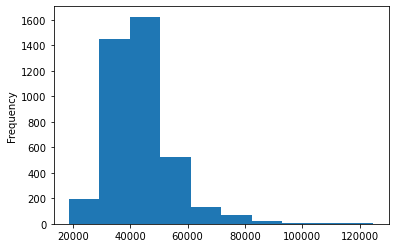

In [56]:
# Find Rows That Need To Be Scaled
college_data['MD_EARN_WNE_P10'].plot.hist()
    

,RET_FT4,CIP14BACHL_0.0,TUITIONFEE_IN,INEXPFTE,ADM_RATE_ALL,C150_4_NRA,TUITIONFEE_OUT,ROOMBOARD_ON,Median Income,C150_4,...,AVGFACSAL,TUITFTE,ADM_RATE,ENDOWEND,median_individual_income_age_25plus_2019,PCIP45,G12MN,Average Income,ENDOWBEGIN,GRADS
0,0.9800,0.0,34986.0,54668.0,0.1248,1.0000,34986.0,10400.0,1.610320,0.9260,...,12371.0,20761.0,0.1248,9.980409e+09,2.510701,0.0446,6539.0,1.908976,8.368066e+09,6048.0
1,0.9774,0.0,40732.0,54653.0,0.0973,0.9011,40732.0,11775.0,1.610320,0.9286,...,14071.0,24305.0,0.0973,9.712628e+09,2.510701,0.0577,6885.0,1.908976,8.317321e+09,6510.0
2,0.9865,0.0,45016.0,62770.0,0.0788,0.8936,45016.0,13224.0,1.610320,0.9130,...,16314.0,28992.0,0.0788,1.242513e+10,2.510701,0.0236,7294.0,1.908976,1.085798e+10,6807.0
3,0.9636,0.0,34998.0,32150.0,0.0884,0.9565,34998.0,10622.0,1.610320,0.9676,...,14742.0,19433.0,0.0884,3.491207e+10,2.510701,0.3545,18445.0,1.908976,2.921943e+10,13042.0
4,0.9718,0.0,39851.0,44736.0,0.0626,0.9739,39851.0,12801.0,1.610320,0.9743,...,15922.0,25999.0,0.0626,3.201273e+10,2.510701,0.3237,20194.0,1.908976,2.756503e+10,17087.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4031,0.7485,1.0,6686.0,5762.0,0.7116,0.5714,16130.0,8400.0,-0.511925,0.5179,...,6004.0,2227.0,0.7116,1.193710e+06,-1.373260,0.0000,1086.0,-0.507589,0.000000e+00,733.0
4032,0.7222,1.0,26430.0,6470.0,0.3810,0.3333,26430.0,7400.0,-0.221834,0.3235,...,2312.0,10300.0,0.3810,1.006900e+07,-1.254000,0.0000,1153.0,-0.408278,1.023000e+07,1052.0
4033,0.8262,1.0,4551.0,4906.0,0.6948,0.2903,13228.0,6224.0,-0.679873,0.2513,...,5566.0,4323.0,0.6948,2.705590e+07,-0.773242,0.0382,805.0,-0.154484,2.643462e+07,557.0
4034,0.7485,1.0,2419.0,8282.0,0.6704,0.5714,8563.0,8400.0,-0.252370,0.5179,...,4916.0,1168.0,0.6705,6.648090e+05,-0.521593,0.0000,1086.0,-0.308967,6.551530e+05,733.0


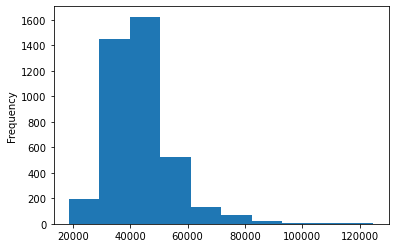

In [40]:
college_data['MD_EARN_WNE_P10'].plot.hist()

y = college_data['MD_EARN_WNE_P10']
X = college_data[cols]
X = X.astype('float64')

for c in X.columns:
    X[c] = X[c].fillna(X[c].median())
    
X

In [41]:
# DUMMY VARIABLES
dummy_vars = []

for c in X.columns:
    l = len(X[c].unique())
    if l < 10:
        dummy_vars.append(c)
        
for c in dummy_vars:
    temp = pd.get_dummies(X[c])
    new_col_name = []
    for t_c in temp.columns:
        new_col_name.append(str(c) + "_" + str(t_c))
    
    temp.columns = new_col_name

    college_data = college_data.join(temp)
    college_data = college_data.drop(c, axis = 1)

In [42]:
        '''
         # KNN with K tuning param
        {'model' : [KNN()],
         'model__n_neighbors':[10,25,50]},

        # Decision Tree with the Max Depth Param
        {'model': [DT()],
         'model__max_depth':[2,3]} 
        '''

import math

# Make to split by the right split by year

def ml_pipeline(X, y):
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.30,random_state=1988)
    use_metrics = ["neg_mean_squared_error"]

    fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)
    # ('pre_process', pp.MinMaxScaler()),
    pipe = Pipeline(steps=[('model',None)])

    search_space = [ 
        # Random forest with the N Estimators tuning param
        {'model' : [RF()],
        'model__max_depth':[12],
        'model__n_estimators':[1500]
        }
    ]

    search = GridSearchCV(pipe, search_space, 
                          cv = fold_generator,
                          scoring='neg_mean_squared_error',
                          n_jobs=15)

    search.fit(train_X,train_y)
    print(search.best_params_)
    print(search.best_score_)
    
    
    val = search.best_score_/len(train_X)
    print(math.sqrt(-1*val))
    return search



In [43]:
s = ml_pipeline(X, y)

{'model': RandomForestClassifier(max_depth=12, n_estimators=1500), 'model__max_depth': 12, 'model__n_estimators': 1500}
nan
nan


In [44]:
import sklearn.metrics as m

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.30,random_state=1988)

rf_mod = s.best_estimator_
p = rf_mod.predict(test_X)
m.mean_absolute_error(test_y,p)

4555.408753096614

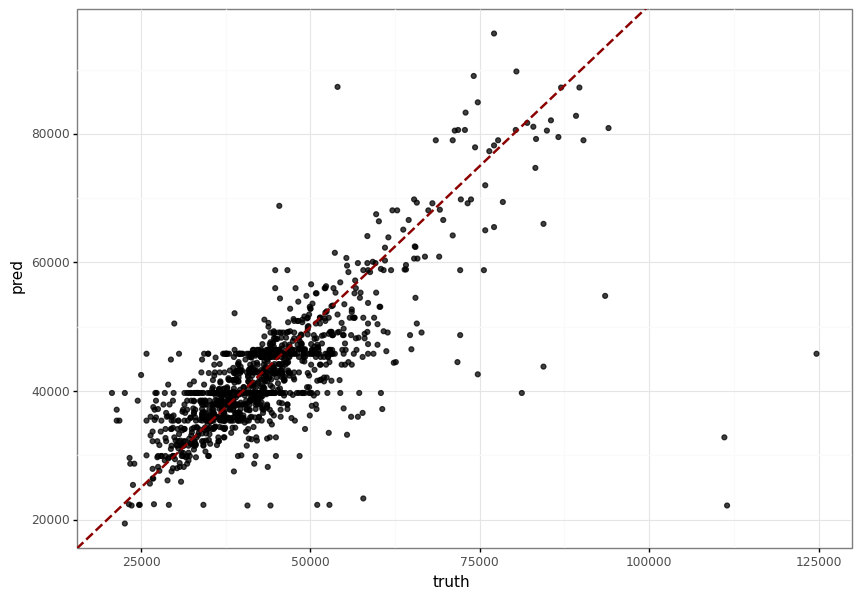

<ggplot: (178103451917)>

In [45]:
(
    ggplot(pd.DataFrame(dict(truth=test_y, pred=p)),
          aes(x='truth',y="pred")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

In [47]:
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=5)


In [49]:
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))
# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,RET_FT4,0.107965,0.003476,0.101014,0.114916
1,AVGFACSAL,0.074053,0.003286,0.067482,0.080625
2,C150_4,0.062301,0.003166,0.055969,0.068633
3,C100_4,0.042124,0.001630,0.038864,0.045384
4,TUITIONFEE_OUT,0.036673,0.002975,0.030722,0.042623
5,SAT_AVG,0.036389,0.001294,0.033802,0.038977
6,PCIP13,0.034973,0.001234,0.032505,0.037442
7,TUITFTE,0.030230,0.000795,0.028641,0.031819
8,ENDOWEND,0.027327,0.003015,0.021297,0.033358
9,INEXPFTE,0.025345,0.002035,0.021276,0.029415


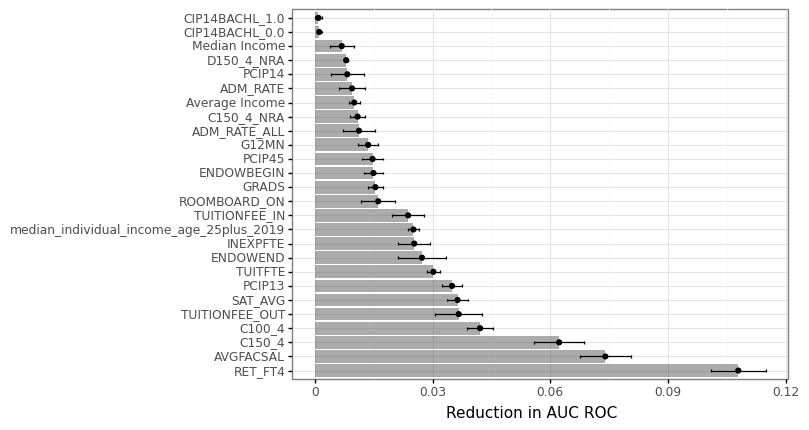

<ggplot: (178103216604)>

In [50]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)